<a href="https://colab.research.google.com/github/jfimbett/RM_Lux/blob/main/practical_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Exercise
## Portfolio Optimization and Risk Management

Consider the problem of dynamically allocating wealth between long and short positions in a portfolio of ETFs. The optimal portfolio will depend on real-world constraints.

$$
\begin{align*}
\max \mathbb{E}[|R_x-\mu(\mathbf{x})|] \\
\text{subject to} \\
\sum_{i=1}^n x_i = 1 \rightarrow \text{     Fully Invested} \\
l_i \leq x_i \leq u_i \text{  }\forall i=1,...,N \rightarrow \text{     Position Limits} \\
\end{align*}
$$

LP Formulation (based on scenario approach):

$$
\begin{align*}
\min \sum_{s=1}^m p_s d_s \\
\text{s.t.} \\
d_s \geq \sum_{j=1}^n x_j R_j(s) - \sum_{j=1}^n x_j \mu_j \\
d_s \geq -(\sum_{j=1}^n x_j R_j(s) - \sum_{j=1}^n x_j \mu_j) \\
\sum_{j=1}^n x_j = 1 \\
\sum_{j=1}^n x_j \mu_j \geq \mu_0 \\
\mu_j = \sum_{s=1}^m p_s R_j(s) \\
l_i \leq x_i \leq u_i  \\
\end{align*}
$$



### Data

In [1]:
!pip install yfinance
!pip install scipy
!pip install matplotlib
!pip install numpy
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
etf_tickers = [
    # SPDR S&P 500 ETF Trust (Large-Cap U.S. Stocks)
    "SPY",

    # Invesco QQQ Trust (Technology)
    "QQQ",

    # Financial Select Sector SPDR Fund (Financials)
    "XLF",

    # Consumer Discretionary Select Sector SPDR Fund (Consumer Discretionary)
    "XLY",

    # Health Care Select Sector SPDR Fund (Healthcare)
    "XLV",

    # Utilities Select Sector SPDR Fund (Utilities)
    "XLU",

    # Energy Select Sector SPDR Fund (Energy)
    "XLE",

    # Industrial Select Sector SPDR Fund (Industrials)
    "XLI",

    # iShares Russell 2000 ETF (Small-Cap U.S. Stocks)
    "IWM",

    # SPDR Gold Trust (Gold)
    "GLD",

    # iShares MSCI EAFE ETF (International Developed Markets)
    "EFA",

    # iShares MSCI Emerging Markets ETF (Emerging Markets)
    "EEM",

    # iShares 20+ Year Treasury Bond ETF (Long-Term Treasury Bonds)
    "TLT",

    # iShares Core U.S. Aggregate Bond ETF (U.S. Aggregate Bonds)
    "AGG",

    # Vanguard Real Estate ETF (Real Estate)
    "VNQ",

    # iShares U.S. Real Estate ETF (U.S. Real Estate)
    "IYR",

    # SPDR S&P Biotech ETF (Biotechnology)
    "XBI",

    # Vanguard FTSE Emerging Markets ETF (Emerging Markets)
    "VWO",

    # Real Estate Select Sector SPDR Fund (Real Estate)
    "XLRE",

    # iShares NASDAQ Biotechnology ETF (Biotechnology)
    "IBB"
]


In [3]:
# Download all available data for each ETF

df = yf.download(etf_tickers, start="2000-01-01", auto_adjust=True)["Close"]

[*********************100%%**********************]  20 of 20 completed


In [4]:
df.tail()

,AGG,EEM,EFA,GLD,IBB,IWM,IYR,QQQ,SPY,TLT,VNQ,VWO,XBI,XLE,XLF,XLI,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,,,,,,,,,,
2023-11-29,96.305092,39.480000,72.480003,189.539993,119.339996,178.979996,83.949997,389.809998,454.609985,92.337616,81.139999,40.509998,73.849998,84.019997,35.500000,105.889999,36.930000,62.490002,129.679993,169.020004
2023-11-30,95.986000,39.560001,72.419998,188.750000,120.930000,179.660004,84.589996,388.829987,456.399994,91.270996,81.730003,40.630001,75.519997,84.580002,35.900002,107.050003,37.230000,62.759998,131.309998,168.779999
2023-12-01,96.830002,39.730000,73.180000,192.009995,122.599998,184.910004,86.570000,389.940002,459.100006,92.989998,83.739998,40.799999,77.830002,85.019997,36.169998,108.739998,38.009998,63.529999,131.830002,171.089996
2023-12-04,96.459999,39.279999,72.610001,187.860001,123.389999,186.889999,87.089996,386.320007,456.690002,92.620003,84.349998,40.439999,79.190002,84.629997,36.130001,108.919998,38.220001,63.279999,132.080002,170.440002
2023-12-05,97.069000,39.069901,72.389900,187.175003,122.989998,184.529999,86.459999,386.940002,456.529999,94.480003,83.680000,40.312000,78.949997,83.394997,35.979301,108.010002,38.014999,62.865002,132.020004,170.919998


In [5]:
# keep last observation of each month
df = df.resample("M").last()
df.tail()

,AGG,EEM,EFA,GLD,IBB,IWM,IYR,QQQ,SPY,TLT,VNQ,VWO,XBI,XLE,XLF,XLI,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,,,,,,,,,,
2023-08-31,95.714043,39.169998,71.529999,180.020004,128.548950,187.728912,84.380402,377.443604,448.767059,95.416023,81.586227,40.202080,79.199997,88.268631,34.227005,107.790894,36.727180,62.453915,132.665848,170.406921
2023-09-30,93.235435,37.950001,68.919998,171.449997,122.290001,176.740005,78.139999,358.269989,427.480011,87.829376,75.660004,39.209999,73.019997,90.389999,33.169998,101.379997,34.070000,58.930000,128.740005,160.979996
2023-10-31,91.771027,36.700001,66.919998,184.089996,113.680000,164.520004,75.330002,350.869995,418.200012,83.031090,72.919998,37.939999,66.230003,85.190002,32.360001,98.360001,33.099998,59.689999,124.540001,152.100006
2023-11-30,95.986000,39.560001,72.419998,188.750000,120.930000,179.660004,84.589996,388.829987,456.399994,91.270996,81.730003,40.630001,75.519997,84.580002,35.900002,107.050003,37.230000,62.759998,131.309998,168.779999
2023-12-31,97.069000,39.069901,72.389900,187.175003,122.989998,184.529999,86.459999,386.940002,456.529999,94.480003,83.680000,40.312000,78.949997,83.394997,35.979301,108.010002,38.014999,62.865002,132.020004,170.919998


In [6]:
# compute monthly returns
returns = df.pct_change().dropna()
returns.tail()

,AGG,EEM,EFA,GLD,IBB,IWM,IYR,QQQ,SPY,TLT,VNQ,VWO,XBI,XLE,XLF,XLI,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,,,,,,,,,,
2023-08-31,-0.006313,-0.066269,-0.039350,-0.012778,-0.004640,-0.050828,-0.030778,-0.014830,-0.016252,-0.031421,-0.033779,-0.058974,-0.060387,0.016461,-0.026889,-0.019833,-0.030636,-0.061279,-0.007007,-0.017440
2023-09-30,-0.025896,-0.031146,-0.036488,-0.047606,-0.048689,-0.058536,-0.073956,-0.050799,-0.047435,-0.079511,-0.072638,-0.024677,-0.078030,0.024033,-0.030882,-0.059475,-0.072349,-0.056424,-0.029592,-0.055320
2023-10-31,-0.015707,-0.032938,-0.029019,0.073724,-0.070406,-0.069141,-0.035961,-0.020655,-0.021709,-0.054632,-0.036215,-0.032390,-0.092988,-0.057528,-0.024420,-0.029789,-0.028471,0.012897,-0.032624,-0.055162
2023-11-30,0.045929,0.077929,0.082188,0.025314,0.063776,0.092025,0.122926,0.108188,0.091344,0.099239,0.120817,0.070901,0.140269,-0.007160,0.109394,0.088349,0.124773,0.051432,0.054360,0.109665
2023-12-31,0.011283,-0.012389,-0.000416,-0.008344,0.017035,0.027107,0.022107,-0.004861,0.000285,0.035159,0.023859,-0.007827,0.045418,-0.014010,0.002209,0.008968,0.021085,0.001673,0.005407,0.012679


In [7]:
# In the scenario approach, we will assume every monthly realization had a 1/T probability of occurring
T = len(returns)
# probability of each scenario
p = np.array([1/T for _ in range(T)])
R = returns.values # R[scenario, asset]
print(R.shape)
print(p.shape)

(98, 20)
(98,)


Example using the scenario approach with $T$ scenarios

- Expected return of every asset: $\mu_j$
- Covariance matrix: $\Sigma_{ij}$

In [8]:
mu = np.array([np.sum([p[s]*R[s,i] for s in range(T)]) for i in range(len(etf_tickers))])
for etf, m in zip(etf_tickers, mu):
    print(f"{etf}: {m*100:.2f}%")

SPY: 0.09%
QQQ: 0.42%
XLF: 0.51%
XLY: 0.63%
XLV: 0.34%
XLU: 0.77%
XLE: 0.54%
XLI: 1.48%
IWM: 1.06%
GLD: 0.00%
EFA: 0.51%
EEM: 0.49%
TLT: 0.55%
AGG: 0.97%
VNQ: 0.96%
IYR: 1.01%
XBI: 0.62%
VWO: 0.73%
XLRE: 0.85%
IBB: 1.04%


### How does python solve an optimization problem?

$$
\begin{align*}
\min_{x \in \mathbb{R}^n} f(x) \\
\text{s.t.} \\
g_i(x) \geq 0 \text{  }\forall i=1,...,m \\
h_j(x) = 0 \text{  }\forall j=1,...,p \\
\end{align*}
$$

It uses gradient descent to find the minimum of the objective function $f(x)$, subject to the constraints $g_i(x)$ and $h_j(x)$ given an initial value $x_0$.

# Example:

$$
\begin{align*}
\min_{x \in \mathbb{R}^2} f(x) = x_1^2 + x_2^2 \\
\text{s.t.} \\
g_1(x) = x_1 + x_2 - 1 \geq 0 \\
h_1(x) = x_1 - 1 = 0 \\
\end{align*}
$$


In [9]:
def obj(x):
    return x[0]**2 + x[1]**2

def g1(x):
    return x[0] + x[1] - 1

def h1(x):
    return x[0] - 1

In [10]:
sol = minimize(obj, [4.0, 4.0], constraints=[{"type": "ineq", "fun": g1},
                                             {"type": "eq",   "fun": h1}])

# Print solution
print(sol)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.0
       x: [ 1.000e+00 -8.882e-16]
     nit: 2
     jac: [ 2.000e+00  1.490e-08]
    nfev: 6
    njev: 2


In [11]:
# Practical exercise

def obj(variables):
    d = variables[:T] # First T variables are the auxiliary variables
    return np.sum([p[s]*d[s] for s in range(T)])

### Inequality Constraints

$$
d_s \geq \sum_{j=1}^n x_j R_j(s) - \sum_{j=1}^n x_j \mu_j \\
d_s \geq -(\sum_{j=1}^n x_j R_j(s) - \sum_{j=1}^n x_j \mu_j) \\
\sum_{j=1}^n x_j \mu_j \geq \mu_0 \\
$$

In [12]:
def ineq1(variables, scenario):
    d_s = variables[scenario]
    x   = variables[T:]
    return d_s - np.sum([x[i]*R[scenario,i] for i in range(len(etf_tickers))]) + np.sum([x[i]*mu[i] for i in range(len(etf_tickers))])

def ineq2(variables, scenario):
    d_s = variables[scenario]
    x   = variables[T:]
    return d_s + np.sum([x[i]*R[scenario,i] for i in range(len(etf_tickers))]) - np.sum([x[i]*mu[i] for i in range(len(etf_tickers))])

def minimum_expected_return(variables, mu0=0.0):
    x = variables[T:]
    return np.sum([x[i]*mu[i] for i in range(len(etf_tickers))]) - mu0

### Equality Constraints

$$
\sum_{j=1}^n x_j = 1 \\
$$

In [13]:
def portfolio_weights(variables):
    return np.sum(variables[T:]) - 1.0

In [14]:
# Bounds, assume only 5% shorting allowed and maximum 50% allocation to any asset
# Define them for every variable
bnds = [(None, None) for _ in range(T)] + [(-0.05, 0.5) for _ in range(len(etf_tickers))]

All together

In [15]:
N = len(etf_tickers)
initial_guess = [0 for _ in range(T)] + [1/N for _ in range(N)]
constraints = [{"type": "ineq", "fun": ineq1, "args": [s]} for s in range(T)] + \
                [{"type": "ineq", "fun": ineq2, "args": [s]} for s in range(T)] + \
                [{"type": "ineq",   "fun": minimum_expected_return}] + \
                [{"type": "eq",   "fun": portfolio_weights}]
sol = minimize(obj, initial_guess, bounds=bnds, constraints=constraints)

# print optimization status
print(f"Optimization status: {sol.success}")

if sol.success:
    for i, etf in enumerate(etf_tickers):
        print(f"{etf}: {sol.x[T+i]*100:.2f}%")
    # Portfolio expected return
    print(f"Portfolio expected return: {np.sum([sol.x[T+i]*mu[i] for i in range(len(etf_tickers))])*100:.2f}%")



Optimization status: True
SPY: 50.00%
QQQ: -5.00%
XLF: -5.00%
XLY: 8.37%
XLV: 1.79%
XLU: -0.20%
XLE: -5.00%
XLI: -0.01%
IWM: 0.66%
GLD: 23.03%
EFA: -5.00%
EEM: 0.66%
TLT: 0.80%
AGG: 8.97%
VNQ: 19.22%
IYR: -5.00%
XBI: -5.00%
VWO: 12.52%
XLRE: 7.29%
IBB: -3.11%
Portfolio expected return: 0.33%


In [16]:
# Sensitivity analysis, change the minimum expected return
from tqdm import tqdm
ers = np.linspace(0.0, 0.01, 5)
objs = []
for er in tqdm(ers):
    constraints = [{"type": "ineq", "fun": ineq1, "args": [s]} for s in range(T)] + \
                    [{"type": "ineq", "fun": ineq2, "args": [s]} for s in range(T)] + \
                    [{"type": "ineq",   "fun": lambda x: minimum_expected_return(x, mu0=er)}] + \
                    [{"type": "eq",   "fun": portfolio_weights}]
    sol = minimize(obj, initial_guess, bounds=bnds, constraints=constraints)
    if sol.success:
        objs.append(sol.fun)
    else:
        objs.append(np.nan)

100%|██████████| 5/5 [02:38<00:00, 31.61s/it]


Text(0, 0.5, 'Objective function')

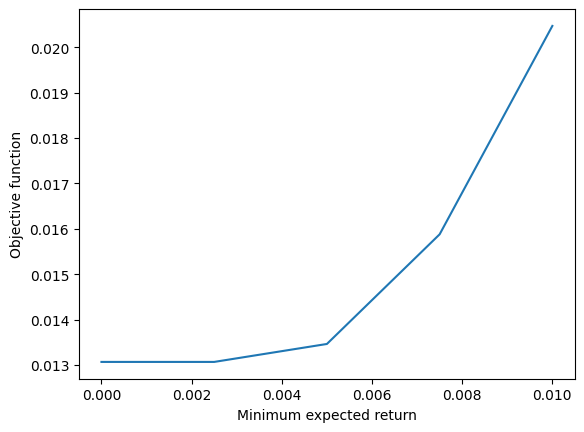

In [17]:
# How does the objective function change with the minimum expected return?
plt.plot(ers, objs)
plt.xlabel("Minimum expected return")
plt.ylabel("Objective function")